# Simple neural network predicting ahead of time

Using [otexts](https://otexts.com/fpp2/nnetar.html) as a reference.

requires tensorflow environment

In [1]:
# import libraries
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist
from tensorflow.keras import callbacks

#pkerastting
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors



[machine learning mastery recommendations for random seed](https://machinelearningmastery.com/reproducible-results-neural-networks-keras/)

> Keras does get its source of randomness from the NumPy random number generator, so this must be seeded regardless of whether you are using a Theano or TensorFlow backend.

In [2]:
from numpy.random import seed
seed(1)
from tensorflow.keras.utils import set_random_seed

In [3]:
#import data
basic_rates_path = '../merged_data/resampled_tudf_minute_basic.csv'
rdf = pd.read_csv(basic_rates_path)

In [4]:
rdf.head()

,created_at,tweet_rate_60,tweet_rate_600,time_since_last_tweet_rolling_60,time_since_last_tweet_rolling_600
0,2022-04-29 19:46:00+00:00,NaN,NaN,NaN,NaN
1,2022-04-29 19:47:00+00:00,NaN,NaN,NaN,NaN
2,2022-04-29 19:48:00+00:00,NaN,NaN,NaN,NaN
3,2022-04-29 19:49:00+00:00,NaN,NaN,NaN,NaN
4,2022-04-29 19:50:00+00:00,0.275387,NaN,3.633333,NaN


<AxesSubplot:>

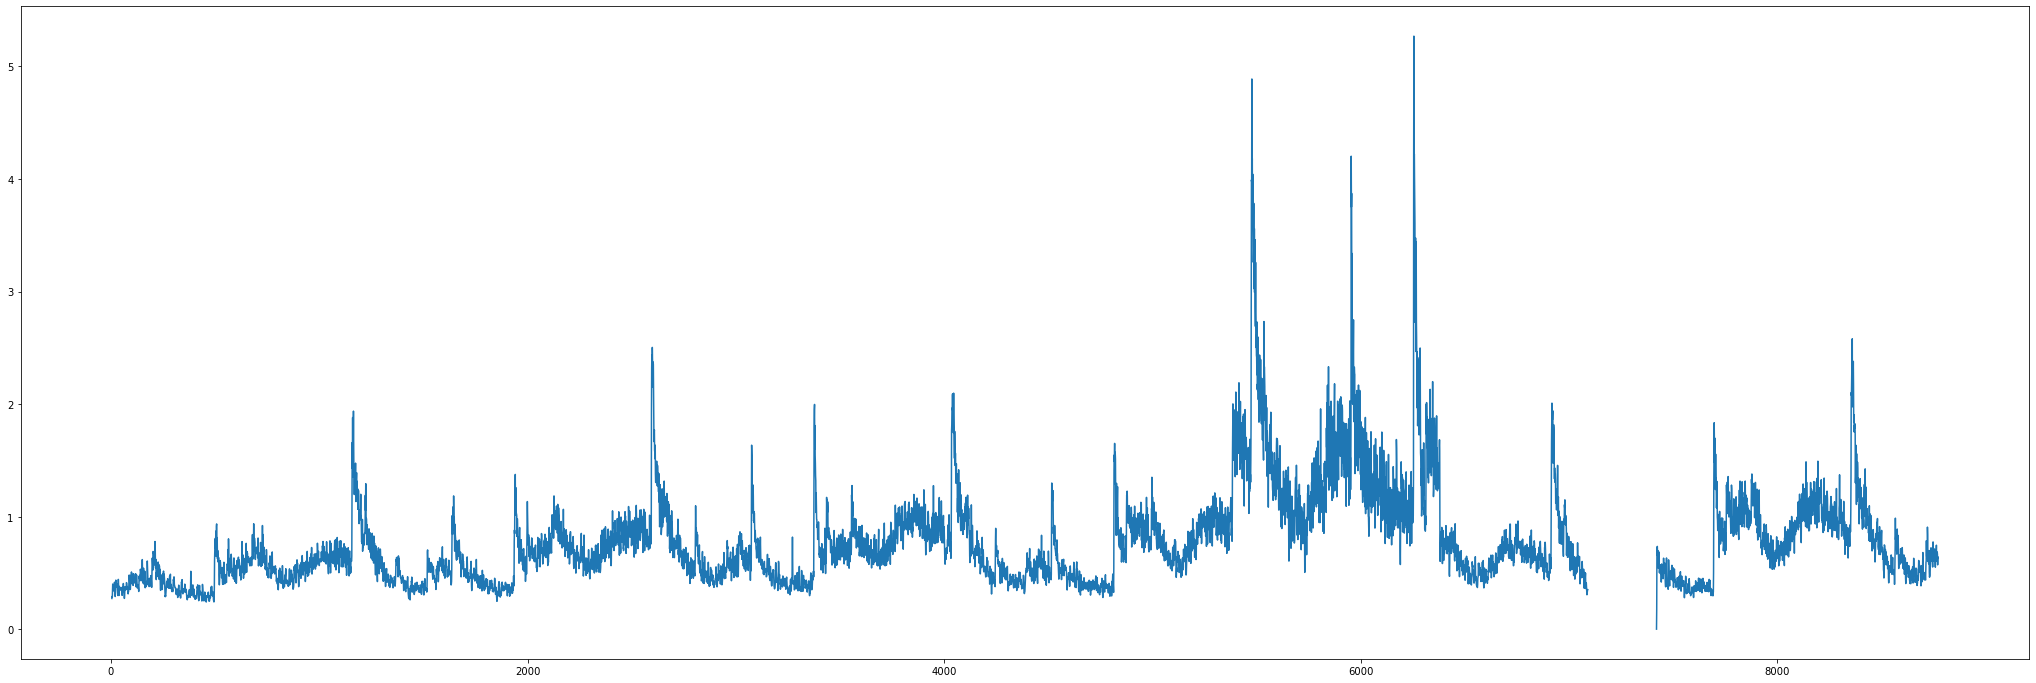

In [5]:
rdf['tweet_rate_60'].plot(figsize=(36,12))

In [6]:
rdf[rdf['tweet_rate_60'].isna()]['created_at']

0       2022-04-29 19:46:00+00:00
1       2022-04-29 19:47:00+00:00
2       2022-04-29 19:48:00+00:00
3       2022-04-29 19:49:00+00:00
7092    2022-05-04 17:58:00+00:00
                  ...            
7416    2022-05-04 23:22:00+00:00
7417    2022-05-04 23:23:00+00:00
7418    2022-05-04 23:24:00+00:00
7419    2022-05-04 23:25:00+00:00
7420    2022-05-04 23:26:00+00:00
Name: created_at, Length: 333, dtype: object

Create a new dataframe of lagged values to input in the NN.

Pick a point in time, then get the last T minutes. These could also be spaced at S skipped intervals. This data will be highly redundant, but prepared ahead of time.

In [7]:
# for each entry in tweet_rate_60,

# create a row in a dataframe with that value and T previous values

number_previous_values = 20  #20 minutes before

tweet_rate_df = pd.DataFrame([rdf['tweet_rate_60'][:5000]]*(number_previous_values+1)).T
tweet_rate_df.dropna(inplace = True)
tweet_rate_df.columns = range(len(tweet_rate_df.columns))
tweet_rate_df.index = rdf['created_at'][:4996]
tweet_rate_df


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
created_at,,,,,,,,,,,,,,,,,,,,,
2022-04-29 19:46:00+00:00,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,...,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387
2022-04-29 19:47:00+00:00,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,...,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223
2022-04-29 19:48:00+00:00,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,...,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841
2022-04-29 19:49:00+00:00,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,...,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971
2022-04-29 19:50:00+00:00,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,...,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03 06:57:00+00:00,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,...,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737
2022-05-03 06:58:00+00:00,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,...,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661
2022-05-03 06:59:00+00:00,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,...,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928


In [8]:
#shift columns
for column in tweet_rate_df.columns:
    tweet_rate_df[column] = tweet_rate_df[column].shift(column)
tweet_rate_df.dropna(inplace = True)
tweet_rate_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
created_at,,,,,,,,,,,,,,,,,,,,,
2022-04-29 20:06:00+00:00,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,0.354769,0.419436,0.415126,0.388040,...,0.374363,0.359368,0.350328,0.364023,0.399959,0.403282,0.334971,0.285841,0.293223,0.275387
2022-04-29 20:07:00+00:00,0.376181,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,0.354769,0.419436,0.415126,...,0.341047,0.374363,0.359368,0.350328,0.364023,0.399959,0.403282,0.334971,0.285841,0.293223
2022-04-29 20:08:00+00:00,0.391300,0.376181,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,0.354769,0.419436,...,0.388040,0.341047,0.374363,0.359368,0.350328,0.364023,0.399959,0.403282,0.334971,0.285841
2022-04-29 20:09:00+00:00,0.397581,0.391300,0.376181,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,0.354769,...,0.415126,0.388040,0.341047,0.374363,0.359368,0.350328,0.364023,0.399959,0.403282,0.334971
2022-04-29 20:10:00+00:00,0.385661,0.397581,0.391300,0.376181,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,...,0.419436,0.415126,0.388040,0.341047,0.374363,0.359368,0.350328,0.364023,0.399959,0.403282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03 06:57:00+00:00,0.770737,0.784215,0.706482,0.800175,0.762062,0.807633,0.826228,0.793047,0.775613,0.755772,...,0.689459,0.704008,0.728153,0.813495,1.019475,0.829359,0.800096,0.809159,1.078092,1.037286
2022-05-03 06:58:00+00:00,1.072661,0.770737,0.784215,0.706482,0.800175,0.762062,0.807633,0.826228,0.793047,0.775613,...,0.785415,0.689459,0.704008,0.728153,0.813495,1.019475,0.829359,0.800096,0.809159,1.078092
2022-05-03 06:59:00+00:00,1.066928,1.072661,0.770737,0.784215,0.706482,0.800175,0.762062,0.807633,0.826228,0.793047,...,0.755772,0.785415,0.689459,0.704008,0.728153,0.813495,1.019475,0.829359,0.800096,0.809159


Each column is now a tweet rate (0) or the rate at the `column` minutes before.

In [9]:
#set up train-test-split.
# no stratify needed. These are numbos.
X_train, X_test, y_train, y_test = train_test_split(tweet_rate_df[range(1,20)],tweet_rate_df[0], train_size=0.8, shuffle = False)

In [10]:
#instantiate keras model
model = Sequential()

#add normal layers
model.add(
    Dense(number_previous_values, activation = 'relu')
)
model.add(
    Dense(number_previous_values, activation = 'relu')
)
model.add(
    Dense(number_previous_values, activation = 'relu')
)
#no activation for output
model.add(
    Dense(1)
)

model.compile(
    loss = 'mean_squared_error',
    optimizer = 'adam'
)

In [21]:
history = model.fit(X_train, y_train,
                   validation_data = (X_test, y_test),
                   batch_size = 256,
                    epochs = 2000
                   )

Epoch 1/2000

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 0s 15ms/step - loss: 0.1492 - val_loss: 0.0258
Epoch 2/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0258 - val_loss: 0.0235
Epoch 3/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0159 - val_loss: 0.0208
Epoch 4/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0137 - val_loss: 0.0198
Epoch 5/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0130 - val_loss: 0.0186
Epoch 6

Epoch 75/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.0099
Epoch 76/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0100
Epoch 77/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.0098
Epoch 78/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0099
Epoch 79/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0097
Epoch 80/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0099
Epoch 81/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0102
Epoch 82/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0097
Epoch 83/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0097
Epoch 84/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0073 - val_los

16/16 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 0.0089
Epoch 236/2000
16/16 [==============================] - ETA: 0s - loss: 0.009 - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0088
Epoch 237/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0088
Epoch 238/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0089
Epoch 239/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0064 - val_loss: 0.0089
Epoch 240/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0089
Epoch 241/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0064 - val_loss: 0.0089
Epoch 242/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0064 - val_loss: 0.0088
Epoch 243/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0064 - val_loss: 0.0089
Epoch 244/2000
16/16 [==============================] - 0s 3ms/step - los

Epoch 394/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0088
Epoch 395/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0089
Epoch 396/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0090
Epoch 397/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0088
Epoch 398/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0088
Epoch 399/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0090
Epoch 400/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0096
Epoch 401/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0089
Epoch 402/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0088
Epoch 403/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0061

16/16 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0088
Epoch 555/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0092
Epoch 556/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0089
Epoch 557/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0088
Epoch 558/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0088
Epoch 559/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0089
Epoch 560/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0089
Epoch 561/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0092
Epoch 562/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0089
Epoch 563/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.

16/16 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0095
Epoch 715/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0090
Epoch 716/2000
16/16 [==============================] - ETA: 0s - loss: 0.005 - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0091
Epoch 717/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0094
Epoch 718/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0089
Epoch 719/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0094
Epoch 720/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0093
Epoch 721/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0091
Epoch 722/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0093
Epoch 723/2000
16/16 [==============================] - 0s 2ms/step - los

16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0095
Epoch 875/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0091
Epoch 876/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0093
Epoch 877/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0092
Epoch 878/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0094
Epoch 879/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0094
Epoch 880/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0093
Epoch 881/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0091
Epoch 882/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0094
Epoch 883/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.

Epoch 1034/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0093
Epoch 1035/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0095
Epoch 1036/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0095
Epoch 1037/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0092
Epoch 1038/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0097
Epoch 1039/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0092
Epoch 1040/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0094
Epoch 1041/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0093
Epoch 1042/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0093
Epoch 1043/2000
16/16 [==============================] - 0s 2ms/step - lo

16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0095
Epoch 1193/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0097
Epoch 1194/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0095
Epoch 1195/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0095
Epoch 1196/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0097
Epoch 1197/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0094
Epoch 1198/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0097
Epoch 1199/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0094
Epoch 1200/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0096
Epoch 1201/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val

16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0095
Epoch 1351/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0096
Epoch 1352/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 1353/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 1354/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0095
Epoch 1355/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0097
Epoch 1356/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0097
Epoch 1357/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 1358/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 1359/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val

16/16 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0097
Epoch 1509/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0099
Epoch 1510/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0099
Epoch 1511/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 1512/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0097
Epoch 1513/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0096
Epoch 1514/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 1515/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0095
Epoch 1516/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 1517/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val

16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 1667/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 1668/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 1669/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0094
Epoch 1670/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0095
Epoch 1671/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0098
Epoch 1672/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0094
Epoch 1673/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0095
Epoch 1674/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 1675/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0053 - val

16/16 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0094
Epoch 1825/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0096
Epoch 1826/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 1827/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0095
Epoch 1828/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0096
Epoch 1829/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0095
Epoch 1830/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0095
Epoch 1831/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0095
Epoch 1832/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0095
Epoch 1833/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val

16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0095
Epoch 1983/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0097
Epoch 1984/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0097
Epoch 1985/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0095
Epoch 1986/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0096
Epoch 1987/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0097
Epoch 1988/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0095
Epoch 1989/2000
16/16 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0097
Epoch 1990/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0099
Epoch 1991/2000
16/16 [==============================] - 0s 4ms/step - loss: 0.0053 - val

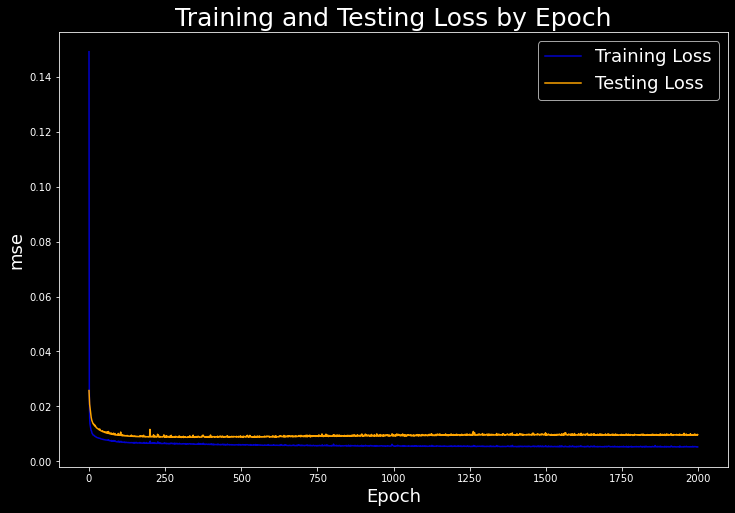

In [22]:
plt.style.use('dark_background')
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color=colors.to_rgba('b',0.8))
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('mse', fontsize = 18)

plt.legend(fontsize = 18);

In [117]:
model.predict(X_test).flatten()

array([0.7598219 , 0.7241607 , 0.6765174 , 0.8020255 , 0.74786216,
       0.719037  , 0.61656487, 0.67119527, 0.7513302 , 0.68962824,
       0.7042813 , 0.67824316, 0.7037946 , 0.7614577 , 0.7401081 ,
       0.73342526, 0.85894036, 0.7001313 , 0.79807276, 0.76759446,
       0.7557104 , 0.91177464, 0.76875496, 0.8148587 , 0.82865167,
       0.82407844, 0.7372851 , 0.806472  , 0.7829907 , 0.72271734,
       0.7098515 , 0.7614976 , 1.3837856 , 1.6323918 , 1.7622415 ,
       1.5916604 , 1.8905036 , 2.2172391 , 2.383856  , 2.241671  ,
       1.6281545 , 1.7605406 , 1.624457  , 1.685488  , 1.9338824 ,
       1.8305482 , 1.6612594 , 1.5915934 , 1.4564296 , 1.5737427 ,
       1.3591399 , 1.4588786 , 1.56659   , 1.3049121 , 1.2884296 ,
       1.3761834 , 1.4199748 , 1.331754  , 1.2380162 , 1.3628052 ,
       1.2558398 , 1.0661138 , 1.1855589 , 1.2181002 , 1.1895317 ,
       1.028237  , 1.1826388 , 1.2406075 , 1.1353658 , 1.0079272 ,
       1.088574  , 1.1854726 , 1.0209358 , 1.1356465 , 1.18866

In [118]:
results = list(model.predict(X_test).flatten())

In [119]:
len(_)

996

In [120]:
results

[0.7598219,
 0.7241607,
 0.6765174,
 0.8020255,
 0.74786216,
 0.719037,
 0.61656487,
 0.67119527,
 0.7513302,
 0.68962824,
 0.7042813,
 0.67824316,
 0.7037946,
 0.7614577,
 0.7401081,
 0.73342526,
 0.85894036,
 0.7001313,
 0.79807276,
 0.76759446,
 0.7557104,
 0.91177464,
 0.76875496,
 0.8148587,
 0.82865167,
 0.82407844,
 0.7372851,
 0.806472,
 0.7829907,
 0.72271734,
 0.7098515,
 0.7614976,
 1.3837856,
 1.6323918,
 1.7622415,
 1.5916604,
 1.8905036,
 2.2172391,
 2.383856,
 2.241671,
 1.6281545,
 1.7605406,
 1.624457,
 1.685488,
 1.9338824,
 1.8305482,
 1.6612594,
 1.5915934,
 1.4564296,
 1.5737427,
 1.3591399,
 1.4588786,
 1.56659,
 1.3049121,
 1.2884296,
 1.3761834,
 1.4199748,
 1.331754,
 1.2380162,
 1.3628052,
 1.2558398,
 1.0661138,
 1.1855589,
 1.2181002,
 1.1895317,
 1.028237,
 1.1826388,
 1.2406075,
 1.1353658,
 1.0079272,
 1.088574,
 1.1854726,
 1.0209358,
 1.1356465,
 1.1886681,
 1.0917844,
 0.9631376,
 0.96770227,
 1.0817001,
 1.0009279,
 0.9448966,
 0.9213918,
 0.9354364,


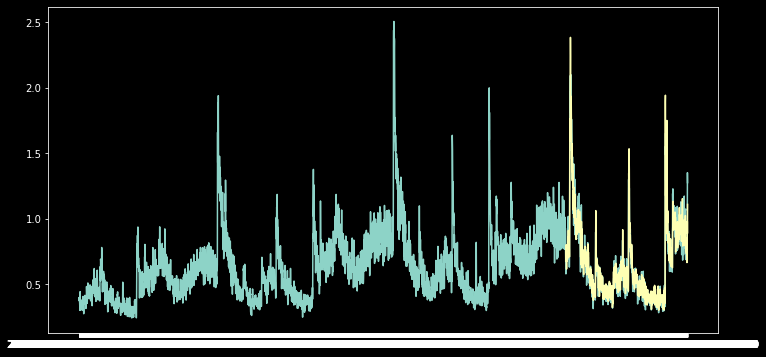

In [121]:
#first neural network results.
plt.figure(figsize=(12,6))
plt.plot(tweet_rate_df.index, tweet_rate_df[0])
plt.plot(tweet_rate_df.index[3980:5000], results)


Text(0.5, 1.0, 'Residuals for tweet rate on first neural network')

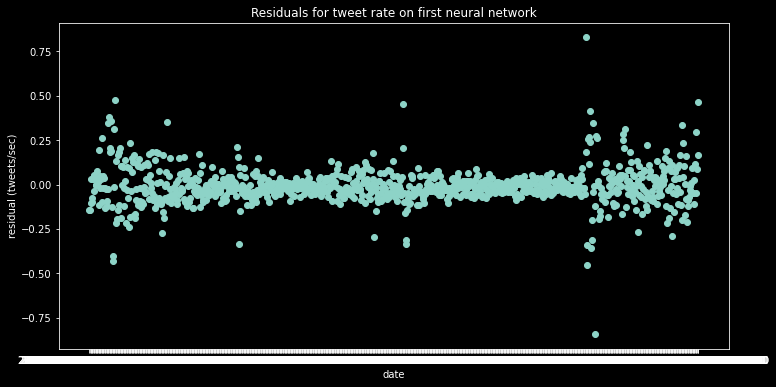

In [129]:
# look at residuals

plt.figure(figsize = (12,6))
plt.scatter(y_test.index, y_test - results)
plt.xlabel('date')
plt.ylabel('residual (tweets/sec)')
plt.title('Residuals for tweet rate on first neural network');

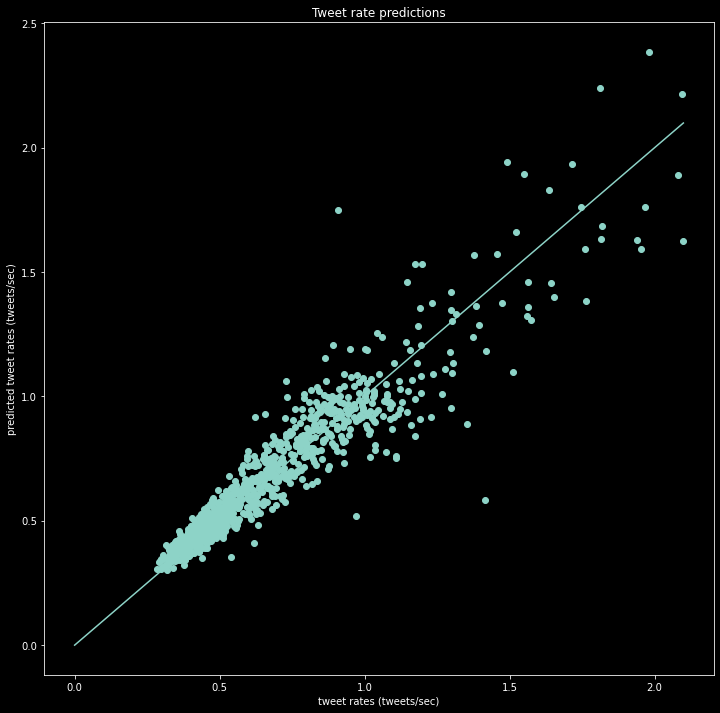

In [130]:
# look at predictions and true values

plt.figure(figsize = (12,12))
plt.scatter( y_test,  results)
plt.xlabel('tweet rates (tweets/sec)')
plt.ylabel('predicted tweet rates (tweets/sec)')
plt.plot([0, y_test.max()], [0,y_test.max()] )
plt.title('Tweet rate predictions');

In [145]:
# get r2 for these
y_test_2 = [ [thing] for thing in y_test]

lr = LinearRegression()
lr.fit(y_test_2, results)
lr.score(y_test_2, results)

0.8866115379563191

In [ ]:
# R2 of 0.89 for this!

In [146]:
residuals = y_test - results

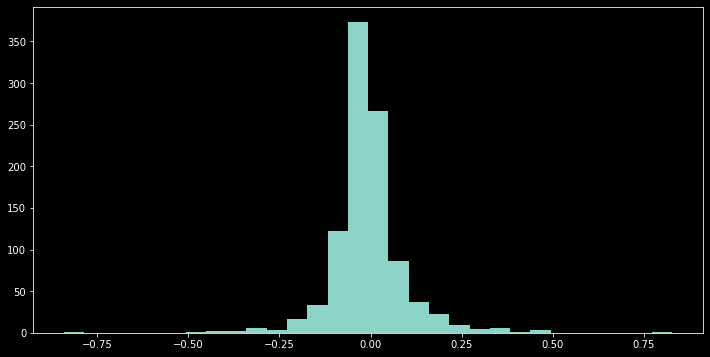

In [151]:
plt.figure(figsize = (12,6))
plt.hist( residuals, bins = 30);

In [152]:
np.std(residuals)

0.10114369780174802

In [153]:
np.mean(residuals)

-0.007593492314530135

The mean is well within the std from zero.

In [111]:
#save the model
first_NN_path = './saved_models/my_first_nn.h5'
model.save(first_NN_path)

### Is this better than just a rolling average?

Probably, but maybe not a exponentially weighted rolling average.

In [29]:
tweet_rate_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
created_at,,,,,,,,,,,,,,,,,,,,,
2022-04-29 20:06:00+00:00,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,0.354769,0.419436,0.415126,0.388040,...,0.374363,0.359368,0.350328,0.364023,0.399959,0.403282,0.334971,0.285841,0.293223,0.275387
2022-04-29 20:07:00+00:00,0.376181,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,0.354769,0.419436,0.415126,...,0.341047,0.374363,0.359368,0.350328,0.364023,0.399959,0.403282,0.334971,0.285841,0.293223
2022-04-29 20:08:00+00:00,0.391300,0.376181,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,0.354769,0.419436,...,0.388040,0.341047,0.374363,0.359368,0.350328,0.364023,0.399959,0.403282,0.334971,0.285841
2022-04-29 20:09:00+00:00,0.397581,0.391300,0.376181,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,0.354769,...,0.415126,0.388040,0.341047,0.374363,0.359368,0.350328,0.364023,0.399959,0.403282,0.334971
2022-04-29 20:10:00+00:00,0.385661,0.397581,0.391300,0.376181,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,...,0.419436,0.415126,0.388040,0.341047,0.374363,0.359368,0.350328,0.364023,0.399959,0.403282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03 06:57:00+00:00,0.770737,0.784215,0.706482,0.800175,0.762062,0.807633,0.826228,0.793047,0.775613,0.755772,...,0.689459,0.704008,0.728153,0.813495,1.019475,0.829359,0.800096,0.809159,1.078092,1.037286
2022-05-03 06:58:00+00:00,1.072661,0.770737,0.784215,0.706482,0.800175,0.762062,0.807633,0.826228,0.793047,0.775613,...,0.785415,0.689459,0.704008,0.728153,0.813495,1.019475,0.829359,0.800096,0.809159,1.078092
2022-05-03 06:59:00+00:00,1.066928,1.072661,0.770737,0.784215,0.706482,0.800175,0.762062,0.807633,0.826228,0.793047,...,0.755772,0.785415,0.689459,0.704008,0.728153,0.813495,1.019475,0.829359,0.800096,0.809159


In [36]:
#create a flat rolling average of last 20 minutes
tweet_rate_df['rolling_average_20'] = tweet_rate_df[tweet_rate_df.columns[1:]].mean(axis = 1)

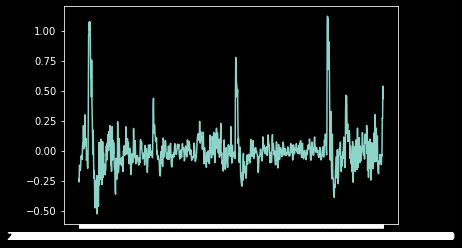

In [39]:
plt.plot(y_test - tweet_rate_df['rolling_average_20'][-996:])

In [41]:
# get r2 for these
y_test_2 = [ [thing] for thing in y_test]

lr = LinearRegression()
lr.fit(y_test_2, tweet_rate_df['rolling_average_20'][-996:])
lr.score(y_test_2, tweet_rate_df['rolling_average_20'][-996:])

0.6526569852692248

The NN is much better than a flat rolling average on the same imput values.
How about exponentially decaying average?

In [66]:
#create exponentially decaying average. The first is weighted fully, successive numbers are limited.
#the decay constant is multiplied a number of times --- it could be converted to exp(~), but that's not necessary.

# with decay_constant -> 0, this approaches the latest value.
# with decay_constant -> 1, this approaches the rolling average..
# as decay constant increases from 1, it weighs older values more than newer ones.
def exponentially_decaying_average(list_of_numbers, decay_constant):
    list_of_numbers_copy = list(list_of_numbers)
    listlen = len(list_of_numbers)
    total_weight = np.sum([
        decay_constant**index
        for index in range(listlen)
    ])
    new_list = [
        list_of_numbers_copy[index]*(decay_constant**index)
        for index in range(listlen)
    ]
    this_average = np.sum(new_list)/total_weight
    return this_average

In [67]:
lag_cols = range(1,21)
exponentially_decaying_average(tweet_rate_df[lag_cols].iloc[0], 1)

0.3584088428931218

In [68]:
exponentially_decaying_average(tweet_rate_df[lag_cols].iloc[0], 0.5)

0.4065388390036363

In [75]:
np.linspace(0.2, 1, 17+1)

array([0.2       , 0.24705882, 0.29411765, 0.34117647, 0.38823529,
       0.43529412, 0.48235294, 0.52941176, 0.57647059, 0.62352941,
       0.67058824, 0.71764706, 0.76470588, 0.81176471, 0.85882353,
       0.90588235, 0.95294118, 1.        ])

In [96]:
#which exponentially decaying average is best?
num_exp_cols = 101

#make a few 
for decay_constant in np.linspace(0, 1, num_exp_cols):
    tweet_rate_df['exp_avg_20_' + str(decay_constant)] = tweet_rate_df[lag_cols].apply(lambda row: exponentially_decaying_average(row[lag_cols], decay_constant), axis = 1)

In [97]:
tweet_rate_df

,0,1,2,3,4,5,6,7,8,9,...,exp_avg_20_0.9,exp_avg_20_0.91,exp_avg_20_0.92,exp_avg_20_0.93,exp_avg_20_0.9400000000000001,exp_avg_20_0.9500000000000001,exp_avg_20_0.96,exp_avg_20_0.97,exp_avg_20_0.98,exp_avg_20_0.99
created_at,,,,,,,,,,,,,,,,,,,,,
2022-04-29 20:06:00+00:00,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,0.354769,0.419436,0.415126,0.388040,...,0.369274,0.368320,0.367339,0.366329,0.365289,0.364218,0.363116,0.361982,0.360819,0.359628
2022-04-29 20:07:00+00:00,0.376181,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,0.354769,0.419436,0.415126,...,0.372227,0.371457,0.370673,0.369873,0.369058,0.368226,0.367378,0.366514,0.365634,0.364739
2022-04-29 20:08:00+00:00,0.391300,0.376181,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,0.354769,0.419436,...,0.373771,0.373217,0.372657,0.372091,0.371519,0.370941,0.370358,0.369770,0.369177,0.368579
2022-04-29 20:09:00+00:00,0.397581,0.391300,0.376181,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,0.354769,...,0.376983,0.376541,0.376111,0.375694,0.375292,0.374906,0.374538,0.374187,0.373856,0.373543
2022-04-29 20:10:00+00:00,0.385661,0.397581,0.391300,0.376181,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,...,0.379910,0.379442,0.378993,0.378566,0.378164,0.377789,0.377443,0.377128,0.376845,0.376596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03 06:57:00+00:00,0.770737,0.784215,0.706482,0.800175,0.762062,0.807633,0.826228,0.793047,0.775613,0.755772,...,0.788507,0.790503,0.792655,0.794965,0.797431,0.800052,0.802823,0.805739,0.808790,0.811968
2022-05-03 06:58:00+00:00,1.072661,0.770737,0.784215,0.706482,0.800175,0.762062,0.807633,0.826228,0.793047,0.775613,...,0.783041,0.784436,0.785942,0.787561,0.789294,0.791139,0.793094,0.795157,0.797322,0.799583
2022-05-03 06:59:00+00:00,1.066928,1.072661,0.770737,0.784215,0.706482,0.800175,0.762062,0.807633,0.826228,0.793047,...,0.811928,0.810289,0.808779,0.807402,0.806163,0.805063,0.804105,0.803288,0.802610,0.802070


<AxesSubplot:xlabel='created_at'>

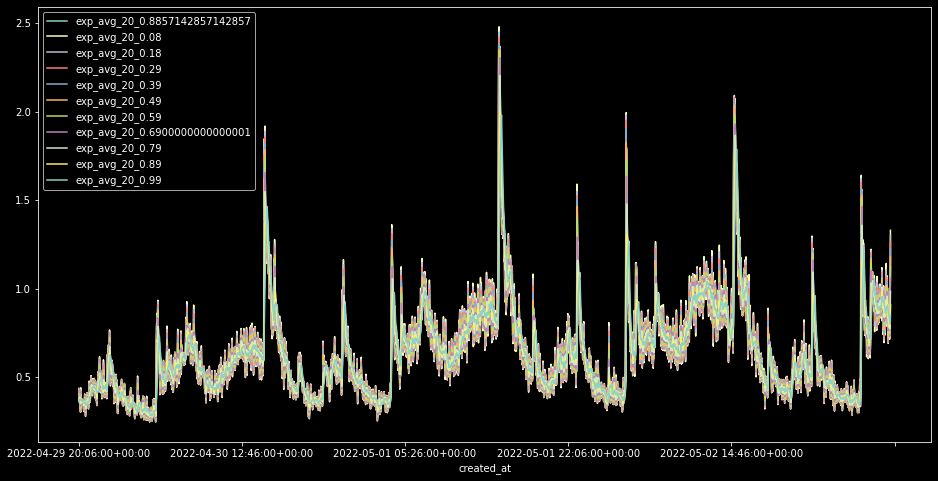

In [99]:
tweet_rate_df[tweet_rate_df.columns[-num_exp_cols::10]].plot(figsize = (16,8))

In [103]:
#get r2 for each
for exp_average_column in tweet_rate_df.columns[-num_exp_cols:]:
    y_test_2 = [ [thing] for thing in y_test]

    lr = LinearRegression()
    lr.fit(y_test_2, tweet_rate_df[exp_average_column][-996:])
    print(f'{exp_average_column}, {lr.score(y_test_2, tweet_rate_df[exp_average_column][-996:])}')

exp_avg_20_0.8857142857142857, 0.7653021728894935
exp_avg_20_1.0, 0.6526569852692248
exp_avg_20_0.0, 0.8925699193910753
exp_avg_20_0.01, 0.8926439060398155
exp_avg_20_0.02, 0.892705065515854
exp_avg_20_0.03, 0.8927534945148318
exp_avg_20_0.04, 0.8927892753142367
exp_avg_20_0.05, 0.8928124756728192
exp_avg_20_0.06, 0.8928231486918117
exp_avg_20_0.07, 0.8928213326373938
exp_avg_20_0.08, 0.8928070507236925
exp_avg_20_0.09, 0.8927803108554656
exp_avg_20_0.1, 0.8927411053294638
exp_avg_20_0.11, 0.8926894104933167
exp_avg_20_0.12, 0.8926251863606303
exp_avg_20_0.13, 0.8925483761808196
exp_avg_20_0.14, 0.8924589059620286
exp_avg_20_0.15, 0.892356683945301
exp_avg_20_0.16, 0.8922416000279721
exp_avg_20_0.17, 0.8921135251340351
exp_avg_20_0.18, 0.8919723105289991
exp_avg_20_0.19, 0.8918177870765025
exp_avg_20_0.21, 0.8914680301817866
exp_avg_20_0.22, 0.8912723488888606
exp_avg_20_0.23, 0.8910624610995537
exp_avg_20_0.24, 0.8908380822483859
exp_avg_20_0.25, 0.8905989014909331
exp_avg_20_0.26, 0.

Unfortunately, the NN is just as good as the null model --- just use the same value as the previous minute (that's exponential decay with a decay constant of 0 --- only the first value is used). Higher decay constants  This means our predictions in general are fine, but we will suffer from sudden shocks. We need to be able to predict these shocks from historical data.

### Second NN

I'd like to use a model that accounts for latest values, but also historical values at key times. This will be like ARIMA, without diffs or all the lags (due to the high frequency data). Using the PACF (and common sense), we can pick out useful time lagged values to feed into the NN.


In [178]:
callback = callbacks.EarlyStopping(monitor='loss', patience=3)
model_2 = Sequential()

#add normal layers
model.add(
    Dense(number_previous_values, activation = 'relu')
)
model_2.add(
    Dense(number_previous_values*2, activation = 'relu')
)
model_2.add(
    Dense(number_previous_values*2, activation = 'relu')
)
model_2.add(
    Dense(number_previous_values/2, activation = 'relu')
)
#no activation for output
model_2.add(
    Dense(1)
)

model_2.compile(
    loss = 'mean_squared_error',
    optimizer = 'adam'
)

In [ ]:
# history_2 = model_2.fit(X_train, y_train,
#                    validation_data = (X_test, y_test),
#                    batch_size = 256,
#                     epochs = 2000
#                    )